# Time Series Classification challange AN2DL Politecnico di Milano 2022
In this notebook there is the definition of the model used for the [AN2DL time series classification challange 2022](https://codalab.lisn.upsaclay.fr/competitions/9056#learn_the_details).

We expect this file to run in a directory where there is a subdirectory with the data at `data/x_train.npy` and `data/y_train.npy`. Another option is to have the zipped file `data/training_dataset_homework2.zip` (if using Colab you need the zip).

## Notebook settings
Here the general settings of the notebook are defined.
- IS_COLAB: True if you are running the notebook from Colab
- COLAB_BASE_DIR: The base directory in Google Drive if you are using Colab

In [19]:
IS_COLAB = True
COLAB_BASE_DIR = '/gdrive/MyDrive/AN2DL/Homework2/' # Change this!

### Connect to Drive

In [20]:
if IS_COLAB:
  from google.colab import drive, runtime
  drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Import Libraries

In [21]:
if IS_COLAB:
  !pip install tensorflow==2.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from shutil import copyfile, make_archive, unpack_archive, move
import random
import sklearn as scikit_learn
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
import math

tfk = tf.keras
print(tf.__version__)

2.10.0


### Seed for reproducibility

In [23]:
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

## Dataset

### Loading

In [24]:
ROOT_DIR = os.getcwd()

if not os.path.exists('data'):
    os.mkdir("data")

if not os.path.exists("data/x_train.npy") or not os.path.exists("data/y_train.npy"):
  if IS_COLAB:
    copyfile(COLAB_BASE_DIR + 'data/training_dataset_homework2.zip', 'data/training_dataset_homework2.zip')
  if os.path.isfile("data/training_dataset_homework2.zip"):
    unpack_archive("data/training_dataset_homework2.zip", "data")
  else:
    raise RuntimeError("please unzip data/training_dataset_homework2.zip")

In [25]:
x_all = np.load("data/x_train.npy")
y_all = np.load("data/y_train.npy")
class_labels = {
    0: 'Wish',
    1: 'Another',
    2: 'Comfortably',
    3: 'Money',
    4: 'Breathe',
    5: 'Time',
    6: 'Brain',
    7: 'Echoes',
    8: 'Wearing',
    9: 'Sorrow',
    10: 'Hey',
    11: 'Shine',
}

### Exploration

In [26]:
print(x_all.shape)
print(y_all.shape)

(2429, 36, 6)
(2429,)


This means we have 2429 sequences, each long 36 units and for each unit we have the measurments of 6 features.

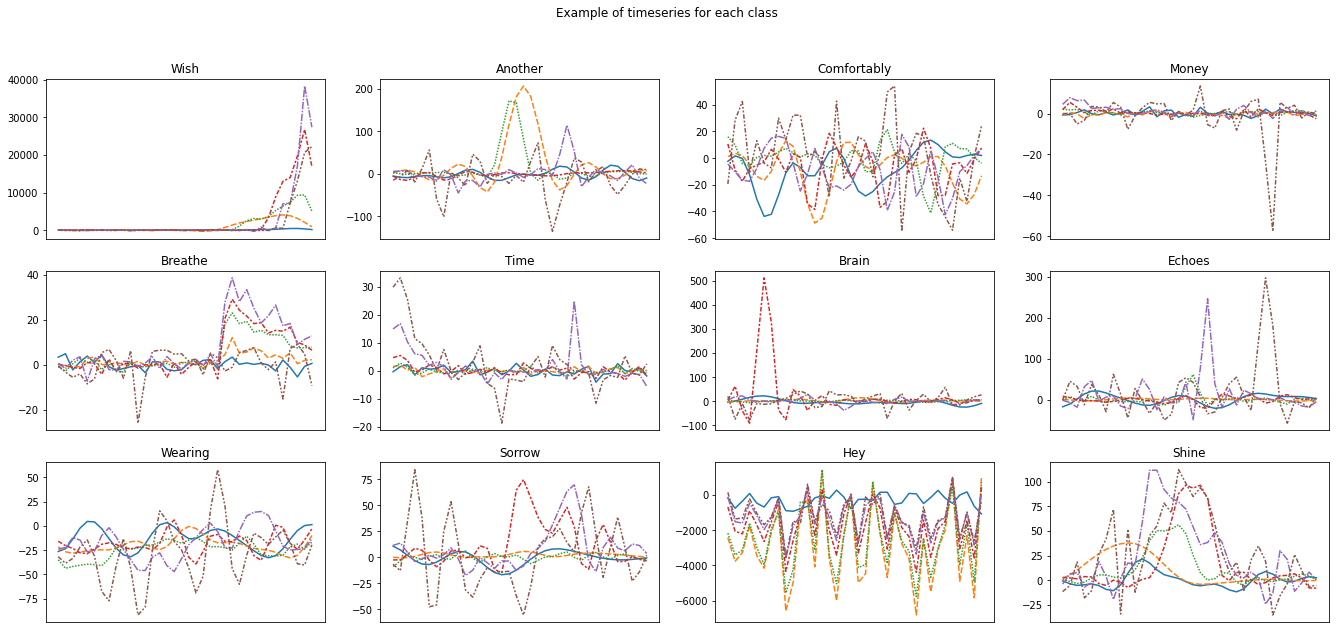

In [27]:
fig, axs = plt.subplots(3, 4, figsize=(23, 10))
fig.suptitle('Example of timeseries for each class')

for i in range(len(class_labels.keys())):
    row, col = i // 4, i % 4
    indicies = np.where(y_all == i)[0]
    random_index = np.random.choice(indicies, size=1)[0]
    sns.lineplot(ax=axs[row, col], data = x_all[random_index])
    axs[row, col].set_title(class_labels[i])
    axs[row, col].get_legend().remove()
    axs[row, col].set_xticks([])
plt.show()

We also notice that the classes are in order:

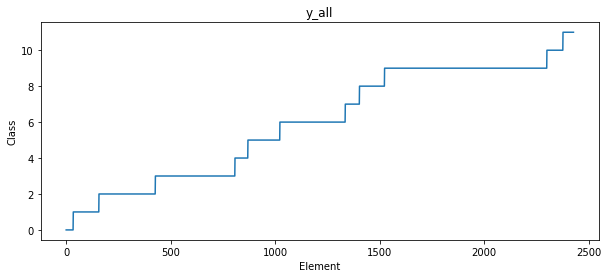

In [28]:
plt.figure(figsize=(10,4))
sns.lineplot(data = y_all)
plt.title('y_all')
plt.ylabel('Class')
plt.xlabel('Element')
plt.show()

But they are not continious nor overlapping sequences:

False


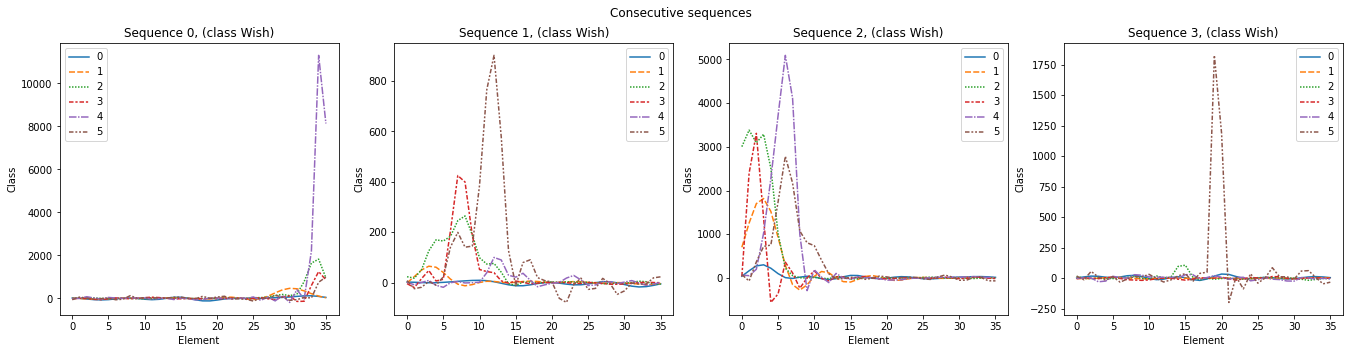

In [29]:
print(np.isin(x_all[0],x_all[1]).any())
fig, axs = plt.subplots(1, 4, figsize=(23, 5))
fig.suptitle('Consecutive sequences')
for i in range(len(axs)):
  sns.lineplot(ax=axs[i], data = x_all[i])
  axs[i].set_title(f"Sequence {i}, (class {class_labels[y_all[i]]})")
  axs[i].set_xlabel("Element")
  axs[i].set_ylabel("Class")
plt.show()

The classes are not balanced:

{'Wish': 34, 'Another': 123, 'Comfortably': 270, 'Money': 381, 'Breathe': 62, 'Time': 153, 'Brain': 313, 'Echoes': 68, 'Wearing': 120, 'Sorrow': 777, 'Hey': 77, 'Shine': 51}


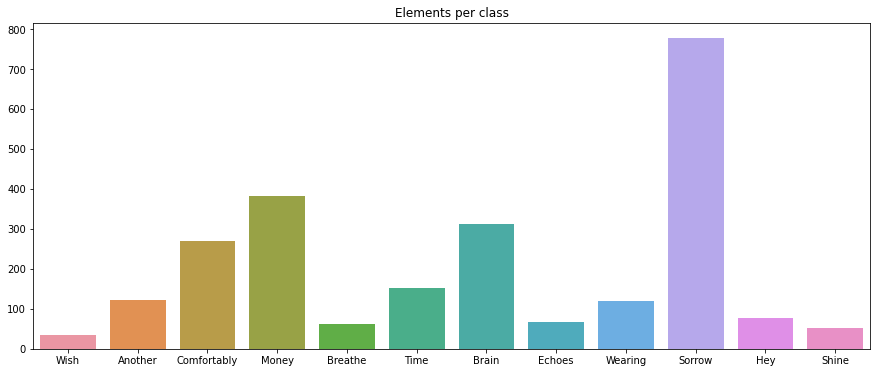

In [30]:
plt.figure(figsize=(15,6))
counts = {}
for k in class_labels.keys():
  counts[class_labels[k]] = np.count_nonzero(y_all == k)
print(counts)
sns.barplot(x = list(counts.keys()), y = [counts[k] for k in counts.keys()])
plt.title('Elements per class')
plt.show()

And the values of the features have a median close to zero:

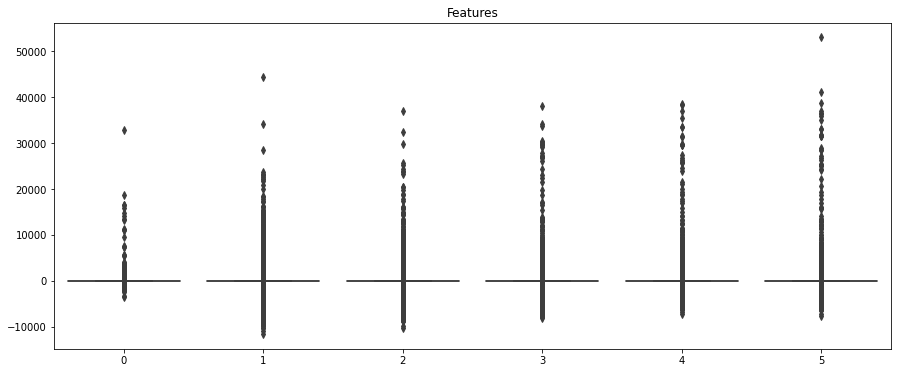

Global mean: 25.29596
Global std: 658.43016
Global median: 0.72032
Global min: -11585.0
Global max: 53020.0
Feature 0: mean=9.57137, std=250.30009, median=0.27551
Feature 1: mean=17.94285, std=776.63375, median=0.41078
Feature 2: mean=26.531, std=699.08726, median=0.65208
Feature 3: mean=32.37399, std=681.84148, median=0.94409
Feature 4: mean=33.87476, std=669.44027, median=1.28675
Feature 5: mean=31.48179, std=730.15455, median=2.11405


In [31]:
plt.figure(figsize=(15,6))
sns.boxplot(data = [x_all[:, :, f].flatten() for f in range(x_all.shape[-1])])
plt.title('Features')
plt.show()

print("Global mean:", np.around(np.mean(x_all[:, :]), 5))
print("Global std:", np.around(np.std(x_all[:, :]), 5))
print("Global median:", np.around(np.median(x_all[:, :]), 5))
print("Global min:", np.around(np.min(x_all[:, :]), 5))
print("Global max:", np.around(np.max(x_all[:, :]), 5))
for f in range(x_all.shape[-1]):
  print(f"Feature {f}: mean={np.around(np.mean(x_all[:, :, f]), 5)}, std={np.around(np.std(x_all[:, :, f]), 5)}, median={np.around(np.median(x_all[:, :, f]), 5)}")

### Split, encoding and preprocessing

Split into train and valdation using the **stratified sampling technique**

In [32]:
TEST_SPLIT = 0.05
VALIDATION_SPLIT = 0.15 # Of the train split

x_train_val, x_test, y_train_val, y_test = train_test_split(x_all, y_all, test_size=TEST_SPLIT, random_state=SEED, stratify=y_all)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=y_train_val)

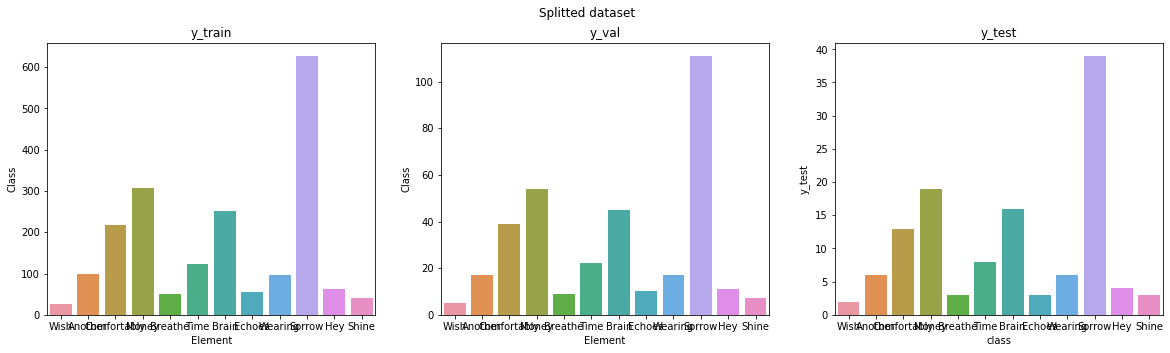

In [33]:
counts_df = pd.DataFrame(columns=['class', 'y_train', 'y_val', 'y_test'])
for k in class_labels.keys():
  counts_df.loc[k] = [
      class_labels[k],
      np.count_nonzero(y_train == k),
      np.count_nonzero(y_val == k),
      np.count_nonzero(y_test == k),
    ]

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Splitted dataset')
axs[0].set_title("y_train")
axs[1].set_title("y_val")
axs[2].set_title("y_test")
sns.barplot(ax=axs[0], x = 'class', y = 'y_train', data = counts_df)
sns.barplot(ax=axs[1], x = 'class', y = 'y_val', data = counts_df)
sns.barplot(ax=axs[2], x = 'class', y = 'y_test', data = counts_df)
for i in range(2):
  axs[i].set_xlabel("Element")
  axs[i].set_ylabel("Class")
plt.show()

Normalize or standardize the features. We can also specify if every feature should be processed singularly or if we should process all the features togheter.

With our experiments we found that the best procedure is to standardize the features singularly.

Old features:
Global mean: 23.67362
Global std: 660.36378
Global median: 0.71365
Global min: -11585.0
Global max: 53020.0
Feature 0: min=-2414.6, max=32932.0, mean=8.87874, std=248.47639, median=0.26506
Feature 1: min=-11585.0, max=44394.0, mean=14.97752, std=740.6545, median=0.4042
Feature 2: min=-9835.3, max=37032.0, mean=26.20202, std=709.79321, median=0.63996
Feature 3: min=-7746.8, max=38086.0, mean=31.18016, std=694.53849, median=0.95456
Feature 4: min=-6711.5, max=38490.0, mean=31.0501, std=675.96261, median=1.26405
Feature 5: min=-7584.1, max=53020.0, mean=29.75319, std=750.07205, median=2.11115

Standardizing singular features with mean/std...
features_mean_std: [(8.878743326346372, 248.47638679481656), (14.977518369699547, 740.6545031381835), (26.20202230721372, 709.7932142504613), (31.180156196201818, 694.5384934262333), (31.050099873015867, 675.9626091302719), (29.753193043523243, 750.0720542856694)]

New features:
Global mean: 0.0
Global std: 1.0
Global median: -0.03565
Gl

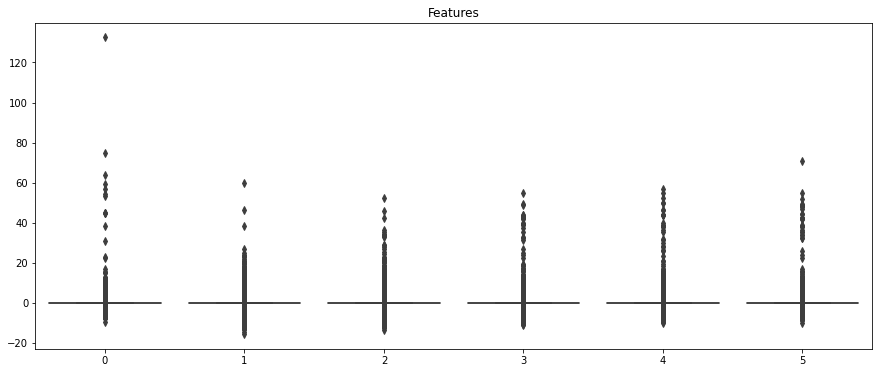

In [34]:
NORMALIZE = False
STANDARDIZE = True
PROCESS_FEATURES_TOGHETER = False

print("Old features:")
print("Global mean:", np.around(np.mean(x_train[:, :]), 5))
print("Global std:", np.around(np.std(x_train[:, :]), 5))
print("Global median:", np.around(np.median(x_train[:, :]), 5))
print("Global min:", np.around(np.min(x_train[:, :]), 5))
print("Global max:", np.around(np.max(x_train[:, :]), 5))
for f in range(x_train.shape[2]):
      print(
        f"Feature {f}: min={np.around(np.min(x_train[:, :, f]), decimals=5)}, "
        f"max={np.around(np.max(x_train[:, :, f]), decimals=5)}, "
        f"mean={np.around(np.mean(x_train[:, :, f]), decimals=5)}, "
        f"std={np.around(np.std(x_train[:, :, f]), decimals=5)}, "
        f"median={np.around(np.median(x_train[:, :, f]), decimals=5)}"
      )

if NORMALIZE:
  if not PROCESS_FEATURES_TOGHETER:
    print("\nNormalizing singular features with min/max...")
    features_min_max = []
    for f in range(x_train.shape[2]):
      max_current_feature = np.max(x_train[:, :, f])
      min_current_feature = np.min(x_train[:, :, f])
      features_min_max.append((min_current_feature, max_current_feature))

      x_train[:, :, f] = (x_train[:, :, f] - min_current_feature) / (max_current_feature - min_current_feature)
      x_val[:, :, f] = (x_val[:, :, f] - min_current_feature) / (max_current_feature - min_current_feature)
      x_test[:, :, f] = (x_test[:, :, f] - min_current_feature) / (max_current_feature - min_current_feature)
    
    print("features_min_max:", features_min_max)
  else:
    print("\nNormalizing all features togheter with min/max...")
    max_all = np.max(x_train[:, :])
    min_all = np.min(x_train[:, :])
    x_train[:, :] = (x_train[:, :] - min_all) / (max_all - min_all)
    x_val[:, :] = (x_val[:, :] - min_all) / (max_all - min_all)
    x_test[:, :] = (x_test[:, :] - min_all) / (max_all - min_all)
elif STANDARDIZE:
  if not PROCESS_FEATURES_TOGHETER:
    print("\nStandardizing singular features with mean/std...")
    features_mean_std = []
    for f in range(x_train.shape[2]):
      mean_current_feature = np.mean(x_train[:, :, f])
      std_current_feature = np.std(x_train[:, :, f])
      features_mean_std.append((mean_current_feature, std_current_feature))

      x_train[:, :, f] = (x_train[:, :, f] - mean_current_feature) / std_current_feature
      x_val[:, :, f] = (x_val[:, :, f] - mean_current_feature) / std_current_feature
      x_test[:, :, f] = (x_test[:, :, f] - mean_current_feature) / std_current_feature
    
    print("features_mean_std:", features_mean_std)
  else:
    print("\nStandardizing all features togheter with mean/std...")
    mean_all = np.mean(x_train[:, :])
    std_all = np.std(x_train[:, :])
    x_train[:, :] = (x_train[:, :] - mean_all) / std_all
    x_val[:, :] = (x_val[:, :] - mean_all) / std_all
    x_test[:, :] = (x_test[:, :] - mean_all) / std_all

print("\nNew features:")
print("Global mean:", np.around(np.mean(x_train[:, :]), 5))
print("Global std:", np.around(np.std(x_train[:, :]), 5))
print("Global median:", np.around(np.median(x_train[:, :]), 5))
print("Global min:", np.around(np.min(x_train[:, :]), 5))
print("Global max:", np.around(np.max(x_train[:, :]), 5))
for f in range(x_train.shape[2]):
      print(
        f"Feature {f}: min={np.around(np.min(x_train[:, :, f]), decimals=5)}, "
        f"max={np.around(np.max(x_train[:, :, f]), decimals=5)}, "
        f"mean={np.around(np.mean(x_train[:, :, f]), decimals=5)}, "
        f"std={np.around(np.std(x_train[:, :, f]), decimals=5)}, "
        f"median={np.around(np.median(x_train[:, :, f]), decimals=5)}"
      )
      
plt.figure(figsize=(15,6))
sns.boxplot(data = [x_train[:, :, f].flatten() for f in range(x_train.shape[-1])])
plt.title('Features')
plt.show()

We noticed that the classes are imbalanced so we used [class weighting](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights)

In [35]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights.flatten()))
print(class_weights_dict)

{0: 6.049382716049383, 1: 1.6333333333333333, 2: 0.7492354740061162, 3: 0.5303030303030303, 4: 3.2666666666666666, 5: 1.3279132791327912, 6: 0.6481481481481481, 7: 2.9696969696969697, 8: 1.6838487972508591, 9: 0.26049973418394473, 10: 2.6344086021505375, 11: 3.983739837398374}


Encode classes with **one-hot**

In [36]:
if len(y_train.shape) == 1:
  y_train = tfk.utils.to_categorical(y_train)
if len(y_val.shape) == 1:
  y_val = tfk.utils.to_categorical(y_val)
if len(y_test.shape) == 1:
  y_test = tfk.utils.to_categorical(y_test)
print("SHAPES:")
print("all (not encoded):", x_all.shape, y_all.shape)
print("train:", x_train.shape, y_train.shape)
print("val:", x_val.shape, y_val.shape)
print("test:", x_test.shape, y_test.shape)

SHAPES:
all (not encoded): (2429, 36, 6) (2429,)
train: (1960, 36, 6) (1960, 12)
val: (347, 36, 6) (347, 12)
test: (122, 36, 6) (122, 12)


## Model

### Model definition

General hyperparameters:

In [37]:
BATCH_SIZE = 32

MAX_EPOCHS = 700
EARLY_STOPPING_PATIENCE = 80
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS = tf.keras.losses.CategoricalCrossentropy()

In [38]:
input_shape = x_train.shape[1:]
n_classes = y_train.shape[-1]

### ResNet+Bidirectional Model

In [39]:
import keras

def build_model(input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = keras.layers.Input(input_shape)
        noise_layer = keras.layers.GaussianNoise(0.4)(input_layer)
        dense_layer_a = tfk.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(noise_layer)
        dense_layer_b = tfk.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(dense_layer_a)
        dense_layer_c = tfk.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(dense_layer_a)
        bid_1 = tfk.layers.Bidirectional(tfk.layers.LSTM(256, return_sequences=True))(dense_layer_c)
        bid_2 = tfk.layers.Bidirectional(tfk.layers.LSTM(256, return_sequences=True))(bid_1)
        dropout = tf.keras.layers.Dropout(0.4)(bid_2)

        # BLOCK 1

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(dropout)
        conv_x = keras.layers.LayerNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.LayerNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.LayerNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.LayerNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.LayerNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.LayerNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.LayerNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.LayerNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.LayerNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.LayerNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.LayerNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_2)
        shortcut_y = keras.layers.LayerNormalization()(shortcut_y)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # BLOCK 4

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_3)
        conv_x = keras.layers.LayerNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.LayerNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.LayerNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_3)
        shortcut_y = keras.layers.LayerNormalization()(shortcut_y)

        output_block_4 = keras.layers.add([shortcut_y, conv_z])
        output_block_4 = keras.layers.Activation('relu')(output_block_4)

        # BLOCK 5

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_4)
        conv_x = keras.layers.LayerNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.LayerNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.LayerNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.LayerNormalization()(output_block_4)

        output_block_4 = keras.layers.add([shortcut_y, conv_z])
        output_block_4 = keras.layers.Activation('relu')(output_block_4)

        # FINAL

        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        dense_layer1 = tfk.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(gap_layer)
        dropout = tf.keras.layers.Dropout(0.4)(dense_layer1)
        dense_layer2 = tfk.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(dense_layer1)
        dropout = tf.keras.layers.Dropout(0.3)(dense_layer2)
        dense_layer3 = tfk.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(dense_layer2)
        dropout = tf.keras.layers.Dropout(0.2)(dense_layer3)
        dense_layer4 = tfk.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-5), kernel_initializer=tfk.initializers.HeUniform(SEED))(dense_layer3)
        
        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(dense_layer4)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

        return model

In [40]:
model = build_model(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 36, 6)       0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 36, 2048)     14336       ['gaussian_noise[0][0]']         
                                                                                                  
 dense_2 (Dense)                (None, 36, 512)      1049088     ['dense[0][0]']                  
                                                                                              

### Model training

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    #class_weight = class_weights_dict,
    batch_size = BATCH_SIZE,
    epochs = MAX_EPOCHS,
    validation_data=(x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=LEARNING_RATE*(1e-5))
    ]
).history

Epoch 1/700
62/62 [==============================] - 12s 64ms/step - loss: 2.3673 - accuracy: 0.3000 - val_loss: 2.0502 - val_accuracy: 0.3718 - lr: 0.0010
Epoch 2/700
62/62 [==============================] - 2s 31ms/step - loss: 1.8314 - accuracy: 0.4092 - val_loss: 1.6248 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 3/700
62/62 [==============================] - 2s 29ms/step - loss: 1.6252 - accuracy: 0.4724 - val_loss: 1.5554 - val_accuracy: 0.4755 - lr: 0.0010
Epoch 4/700
62/62 [==============================] - 2s 30ms/step - loss: 1.5165 - accuracy: 0.5148 - val_loss: 1.4884 - val_accuracy: 0.5303 - lr: 0.0010
Epoch 5/700
62/62 [==============================] - 2s 31ms/step - loss: 1.3858 - accuracy: 0.5372 - val_loss: 1.4224 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 6/700
62/62 [==============================] - 2s 31ms/step - loss: 1.3461 - accuracy: 0.5531 - val_loss: 1.5444 - val_accuracy: 0.5648 - lr: 0.0010
Epoch 7/700
62/62 [==============================] - 2s 31ms/step - l

### Results

Learning curves:

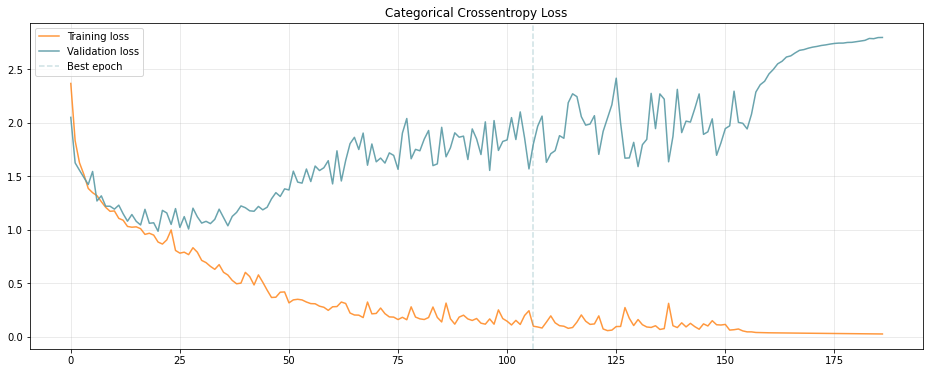

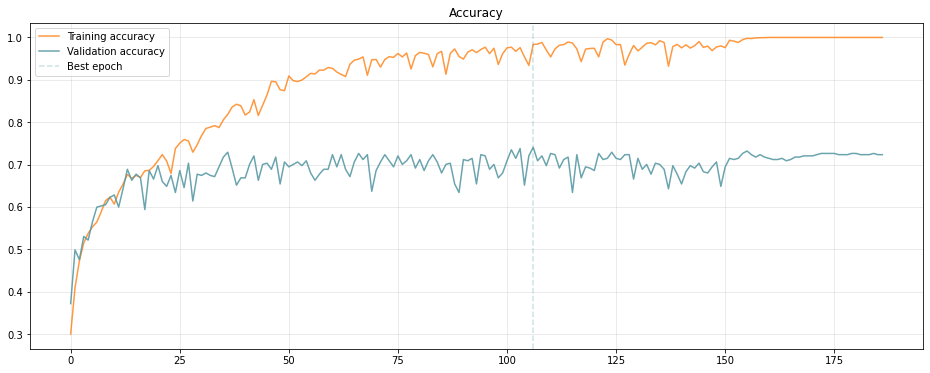

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(16,6))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
def evaluate(model, x, y):
  predictions = model.predict(x)

  # Compute the classification metrics
  accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))


  fig, axs = plt.subplots(1, 2, figsize=(24, 7))

  # Classes counts
  axs[0].set_title("Elements per class")
  counts_df = pd.DataFrame(columns=['class', 'y', 'predictions'])
  for k in class_labels.keys():
    counts_df.loc[k] = [class_labels[k], np.count_nonzero(np.argmax(y, axis=-1) == k), np.count_nonzero(np.argmax(predictions, axis=-1) == k)]
  counts_df.plot(x="class", y=["y", "predictions"], kind="bar", rot=0, ax=axs[0])

  # Plot the confusion matrix
  axs[1].set_title('Confusion Matrix')
  cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
  sns.heatmap(cm.T, cmap='Blues', xticklabels=list(class_labels.values()), yticklabels=list(class_labels.values()), ax=axs[1])
  axs[1].set_xlabel('True labels')
  axs[1].set_ylabel('Predicted labels')

  plt.show()

Evaluate on validation set:

In [ ]:
evaluate(model, x_val, y_val)

Evaluation on test set:

In [ ]:
evaluate(model, x_test, y_test)

## Save the model and create submission

In [ ]:
now = datetime.today().strftime("%Y-%m-%d-%H-%M-%S")
SUBMISSION_DIR = f'submission-{now}'
MODEL_DIR = f'model-{now}'

if not os.path.exists("submissions/"):
    os.mkdir("submissions/")
if not os.path.exists("models/"):
    os.mkdir("models/")

os.mkdir("submissions/" + SUBMISSION_DIR)

with open(os.path.join("submissions", SUBMISSION_DIR, "metadata"), "a") as f:
  pass

In [ ]:
%%writefile submissions/$SUBMISSION_DIR/model.py
import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        # Standardization (REMEMBER TO UPDATE THIS VALUES IF YOU CHANGE THE SPLIT SIZES)
        features_mean_std = [(8.878743326346372, 248.47638679481656), (14.977518369699547, 740.6545031381835), (26.20202230721372, 709.7932142504613), (31.180156196201818, 694.5384934262333), (31.050099873015867, 675.9626091302719), (29.753193043523243, 750.0720542856694)]
        X_as_array = X.numpy()
        for f in range(len(features_mean_std)):
          mean_current_feature, std_current_feature = features_mean_std[f]
          X_as_array[:,:, f] = (X_as_array[:,:, f] - mean_current_feature) / std_current_feature

        out = self.model.predict(X_as_array)
        out = tf.argmax(out, axis=-1)

        return out

Writing submission-2022-12-17-11-54-54/model.py


In [ ]:
# Save model inside submission
model.save("submissions/" + SUBMISSION_DIR + '/SubmissionModel')

# Zip model
make_archive("models/" + MODEL_DIR, 'zip', "submissions/" + SUBMISSION_DIR + '/SubmissionModel')

# Zip submission
make_archive("submissions/" + SUBMISSION_DIR, 'zip', "submissions/" + SUBMISSION_DIR)

# Copy to Drive
if IS_COLAB:
  if not os.path.exists(COLAB_BASE_DIR + "submissions/"):
    os.mkdir(COLAB_BASE_DIR + "submissions/")
  if not os.path.exists(COLAB_BASE_DIR + "models/"):
    os.mkdir(COLAB_BASE_DIR + "models/")
  copyfile("submissions/" + SUBMISSION_DIR + '.zip', COLAB_BASE_DIR + "submissions/" + SUBMISSION_DIR + '.zip')
  copyfile("models/" + MODEL_DIR + '.zip', COLAB_BASE_DIR + "models/" + MODEL_DIR + '.zip')

'/content/submission-2022-12-17-11-54-54.zip'

In [ ]:
# Close colab connection
if IS_COLAB and False:
  runtime.unassign()